## Imports

In [4]:
import os
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import sqlite3
import seaborn as sns
from sklearn import tree

### Column Descriptions

In [5]:
data_dictionary = pd.read_excel("../assets/lending-club-loan-data/LCDataDictionary.xlsx")
# data_dictionary

In [6]:
pd.set_option("display.width",500)
pd.set_option("max_colwidth",500)
pd.set_option("max_rows",100)
data_dictionary.sort_values('LoanStatNew')

,LoanStatNew,Description
75,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
0,addr_state,The state provided by the borrower in the loan application
70,all_util,Balance to credit limit on all trades
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower


In [7]:
pd.set_option("display.width",200)
pd.set_option("max_colwidth",80)
pd.set_option("max_rows",80)

In [8]:
col_of_interest = [
'annual_inc',  'delinq_2yrs',  'dti',
'emp_length',  'grade',        'home_ownership',
'installment', 'int_rate',     'loan_amnt',
'loan_status', 'purpose',      'sub_grade',
'term']

In [9]:
query_base = "select {} from loan;".format(','.join(col_of_interest))
query_base

'select annual_inc,delinq_2yrs,dti,emp_length,grade,home_ownership,installment,int_rate,loan_amnt,loan_status,purpose,sub_grade,term from loan;'

https://www.healthcare.gov/glossary/federal-poverty-level-FPL/

In [10]:
query_full = """
select
    round(loan.annual_inc/1000,0) * 1000 as rounded_annual_inc
    ,round(loan.annual_inc/12060,0) as poverty_inc_mult
    ,delinq_2yrs
    ,case when dti < 1 then round(dti,1)
          when dti < 10 then round(dti/10,1) * 10
          when dti < 100 then round(dti/100,1) * 100
          when dti >=100 then round(dti/1000,1) * 1000
          else 0 end as dti
    ,case when emp_length like '10%' then 10
          when emp_length like '9%' then 9
          when emp_length like '8%' then 8
          when emp_length like '7%' then 7
          when emp_length like '6%' then 6
          when emp_length like '5%' then 5
          when emp_length like '4%' then 4
          when emp_length like '3%' then 3
          when emp_length like '2%' then 2
          when emp_length like '1 %' then 1
          when emp_length = '< 1 year' then 1
          else 0 end as emp_length_int
    ,grade
    ,home_ownership
    ,installment
    ,int_rate
    ,loan_amnt
    ,loan_status
    ,purpose
    ,sub_grade
    ,case when term like '%36%' then 36
          when term like '%60%' then 60
          else 0 end as term
    ,case when loan_status in ('Issued','Current','In Grace Period') then 'holdout'
           when loan_status like '%Fully Paid' then 'good'
           when loan_status in ('Charged Off','Default','Late (16-30 days)'
           ,'Does not meet the credit policy. Status:Charged Off'
           ,'Late (31-120 days)'
           ) then 'bad'
           else 'ignore' end as 'outcome_bucket_text'
    ,case when loan_status in ('Issued','Current','In Grace Period') then -1
           when loan_status like '%Fully Paid' then 1
           when loan_status in ('Charged Off','Default','Late (16-30 days)'
           ,'Does not meet the credit policy. Status:Charged Off'
           ,'Late (31-120 days)'
           ) then 0
           else -1 end as 'label'

from loan
where annual_inc >= 0
    and delinq_2yrs >= 0
    and dti >= 0
    and emp_length is not null
    and grade is not null
    and home_ownership is not null
    and installment >= 0
    and int_rate is not null
    and loan_amnt >= 0
    and loan_status is not null
    and purpose is not null
    and sub_grade is not null
    and term is not null
;
"""

In [11]:
_table_connection = sqlite3.connect('../assets/lending-club-loan-data/database.sqlite')
loandf = pd.read_sql(query_full,_table_connection)
_table_connection.close()

In [12]:
loandf.head()

,rounded_annual_inc,poverty_inc_mult,delinq_2yrs,dti,emp_length_int,grade,home_ownership,installment,int_rate,loan_amnt,loan_status,purpose,sub_grade,term,outcome_bucket_text,label
0,24000.0,2.0,0.0,30.0,10,B,RENT,162.87,10.65%,5000.0,Fully Paid,credit_card,B2,36,good,1
1,30000.0,2.0,0.0,1.0,1,C,RENT,59.83,15.27%,2500.0,Charged Off,car,C4,60,bad,0
2,12000.0,1.0,0.0,9.0,10,C,RENT,84.33,15.96%,2400.0,Fully Paid,small_business,C5,36,good,1
3,49000.0,4.0,0.0,20.0,10,C,RENT,339.31,13.49%,10000.0,Fully Paid,other,C1,36,good,1
4,80000.0,7.0,0.0,20.0,1,B,RENT,67.79,12.69%,3000.0,Current,other,B5,60,holdout,-1


In [13]:
loandf['int_rate'] = loandf.int_rate.str.strip()
loandf['interest_rate'] = loandf.int_rate.str.strip('%')
loandf.interest_rate = pd.to_numeric(loandf['interest_rate'])

In [14]:
loandf['log_ann_inc'] = loandf.rounded_annual_inc.apply(pd.np.log)

In [15]:
loandf.delinq_2yrs.unique()

array([  0.,   2.,   3.,   1.,   4.,   6.,   5.,   8.,   7.,   9.,  11.,
        13.,  15.,  10.,  12.,  17.,  18.,  29.,  24.,  14.,  21.,  22.,
        19.,  16.,  30.,  26.,  20.,  27.,  39.])

In [16]:
loandf.shape

(887353, 18)

###### loandf.delinq_2yrs.replace(to_replace=pd.np.nan,value=0, inplace=True)

print(loandf.emp_length.unique())  
print(loandf.home_ownership.unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' 'n/a' None]  
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' None 'ANY']

col_0	count  
loan_status	 

*can use for holdout dataset: 14713+601781=616494*  
Issued	8460  
Current	601781  
In Grace Period	6253  

*outcome we want: 209712*  
Does not meet the credit policy. Status:Fully Paid	1988  
Fully Paid	207724  

*outcome we don't want: 61176*  
**Charged Off	45248**  
**Default	1219**  
**Does not meet the credit policy. Status:Charged Off	761**  
**Late (16-30 days)	2357**  
**Late (31-120 days)	11591**  

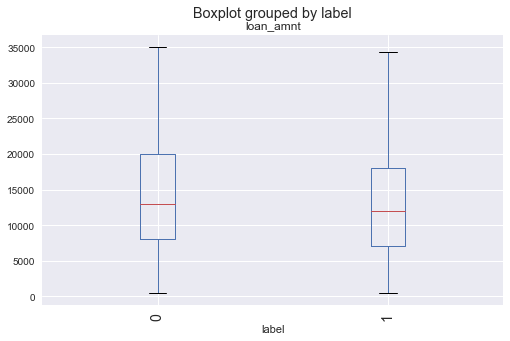

In [23]:
loandf[loandf['label']>=0].boxplot(column='loan_amnt', by ='label',rot=90, figsize=(8,5) , fontsize=14)

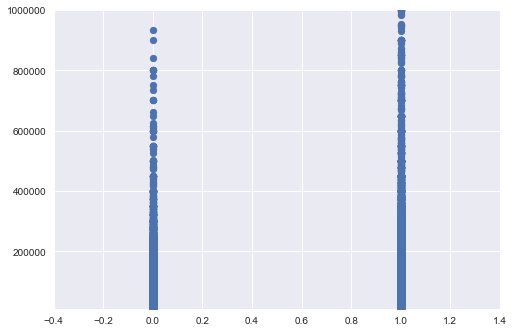

In [37]:
# rounded_annual_inc
# loandf[loandf['label']>=0].boxplot(column='rounded_annual_inc', by ='label',rot=90, figsize=(8,4) , fontsize=14)

sc1 = plt.scatter(loandf.label, loandf.rounded_annual_inc)
sc1ax = plt.gca()
sc1ax.axis([-0.4,1.4,1e4,1e6])
plt.show()

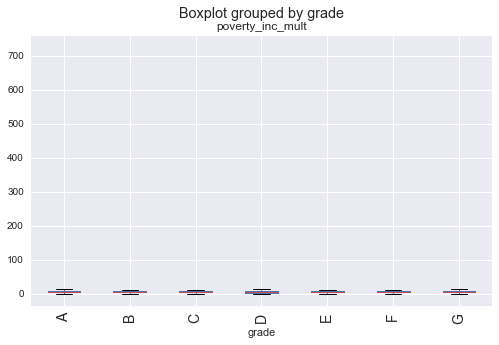

In [40]:
loandf[loandf['label']>=0].boxplot(column='poverty_inc_mult', by ='grade',rot=90, figsize=(8,5) , fontsize=14)